Changes from v2

- implemented the possiblity to add nodes to the system
- add new visualization based data frame

**Importing Dependencies**

In [25]:
# Imports
# Gymnasium imports
import gymnasium as gym 
from gymnasium import Env
from gymnasium.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

# Import helpers
import numpy as np
import pandas as pd
import random
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

from collections import deque

# Import stable baselines
# Probably not needed --> test ray lib instead
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

from Environment.env_v3 import *
from Functions.visualization_functions import *

**Configuration of the Scenario**

In [2]:
# Configuration of the network
# Sample JSON configuration (replace this with your JSON data)
network_config = """
{
  "nodes": {
    "A": { "type": "manufacturer", "I": 30 },
    "B": { "type": "manufacturer", "I": 28 },
    "C": { "type": "manufacturer", "I": 32 },
    "D": { "type": "distributor" },
    "S": { "type": "source" }
  },
  "edges": [
    { "source": "S", "target": "A", "L": 3, "D": 0 },
    { "source": "S", "target": "B", "L": 3, "D": 0 },
    { "source": "S", "target": "C", "L": 3, "D": 0 },
    { "source": "A", "target": "D", "L": 5, "D": 0 },
    { "source": "B", "target": "D", "L": 5, "D": 0 },
    { "source": "C", "target": "D", "L": 5, "D": 0 }
  ]
}
"""

# TODO : Implement configuaration for cost and demand (actual and exptected)

**Building the environment**

In [3]:
EP_LENGTH = 30 # Length of the episode

env = SS_Mngmt_Env(network_config=network_config,
                   EP_LENGTH=EP_LENGTH,
                   render_mode="human")

In [4]:
list(env.graph.nodes())

['A', 'B', 'C', 'D', 'S']

Node Attributes:
Node A: {'type': 'manufacturer', 'I': 30}
Node B: {'type': 'manufacturer', 'I': 28}
Node C: {'type': 'manufacturer', 'I': 32}
Node D: {'type': 'distributor'}
Node S: {'type': 'source'}


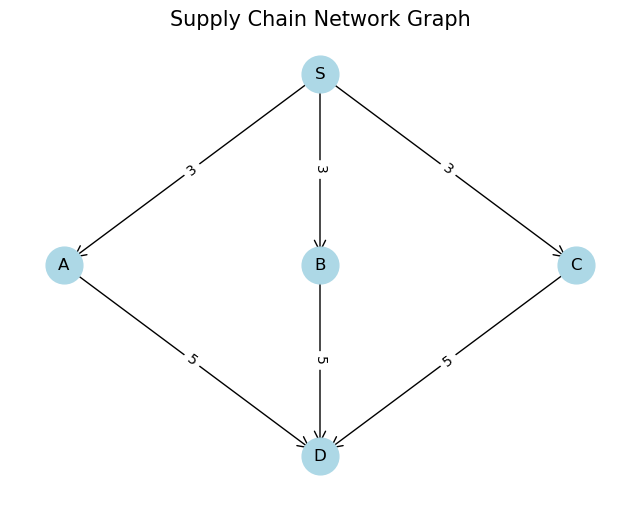

In [5]:
env.render_network()

In [6]:
env.order_queues

{'A': deque([0, 0, 0], maxlen=3),
 'B': deque([0, 0, 0], maxlen=3),
 'C': deque([0, 0, 0], maxlen=3)}

In [7]:
from stable_baselines3.common.env_checker import check_env

check_env(env, warn=True)

/Users/jonasrenfer/miniconda3/envs/rl-scm/lib/python3.12/site-packages/stable_baselines3/common/env_checker.py:263: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(
/Users/jonasrenfer/miniconda3/envs/rl-scm/lib/python3.12/site-packages/stable_baselines3/common/env_checker.py:453: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(
/Users/jonasrenfer/miniconda3/envs/rl-scm/lib/python3.12/site-packages/stable_baselines3/common/env_checker.py:464: UserWarning: Your action space has dtype int64, we recommend using np.float32 to avoid cast errors.
  warnings.warn(


**Testng the environment**

In [8]:
env = SS_Mngmt_Env(network_config=network_config,
                   EP_LENGTH=EP_LENGTH,
                   render_mode="human")

episodes = 1
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        action = env.action_space.sample()
        n_state, reward, done, info, _ = env.step(action)
        score += reward

        # print('Step t:{} Score:{} Stock:{} Order:{} Delivered:{} Exp Demand t+3:{} Act Demand:{}'.format((EP_LENGTH - env.episode_length), score, n_state[0], action, env.delivered, n_state[1], env.demand))

        # env.render()

    # print(env.order_history)

Episode Length: 1
Stock Level: [30.         15.04324157 19.58803089]
Planned Demand: [ 0.         13.25287503  8.82648769]
Actual Demand: [ 0.         12.95675843 12.41196911]
Action: [33 23  0]
Order: [0, 0, 0]
Reward: -32.31563623124444

Episode Length: 2
Stock Level: [ 4.23051907 15.04324157 16.81836358]
Planned Demand: [12.56357127  0.         10.47219367]
Actual Demand: [25.76948093  0.          2.76966731]
Action: [98 32 73]
Order: [0, 0, 0]
Reward: -50.36169834432516

Episode Length: 3
Stock Level: [ 4.23051907 15.04324157  6.74547959]
Planned Demand: [0.         0.         7.15153387]
Actual Demand: [ 0.          0.         10.07288399]
Action: [68  5 33]
Order: [0, 0, 0]
Reward: -63.37131846229021

Episode Length: 4
Stock Level: [37.23051907 22.32815154  6.74547959]
Planned Demand: [ 0.         12.93899206  9.71931404]
Actual Demand: [ 0.         15.71509003 17.83078145]
Action: [85 24 90]
Order: [33, 23, 0]
Reward: -386.52339356717846

Episode Length: 5
Stock Level: [123.2155

**Train Model**


In [10]:
log_path = os.path.join('Training', 'Logs')
model_path = os.path.join('Training', 'Models', 'PPO')

In [11]:
env = SS_Mngmt_Env(network_config=network_config,
                   EP_LENGTH=EP_LENGTH,
                   render_mode="human")

env = DummyVecEnv([lambda: env])

model = PPO("MlpPolicy", env, verbose=1, tensorboard_log=log_path)

Using cpu device


In [12]:
model.learn(total_timesteps=100000)

Logging to Training/Logs/PPO_27
-----------------------------
| time/              |      |
|    fps             | 6534 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 3541         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0014137069 |
|    clip_fraction        | 0.000635     |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.26        |
|    explained_variance   | 5.85e-05     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.1e+07      |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00279     |
|    std                  | 1            |
|    value_loss           |

In [13]:
evaluate_policy(model, env, n_eval_episodes=1, render=False, return_episode_rewards=True)

/Users/jonasrenfer/miniconda3/envs/rl-scm/lib/python3.12/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


([-9811.833892822266], [30])

In [26]:
df = pd.read_csv('./Data/2024-10-13_17_last_environment_data.csv')

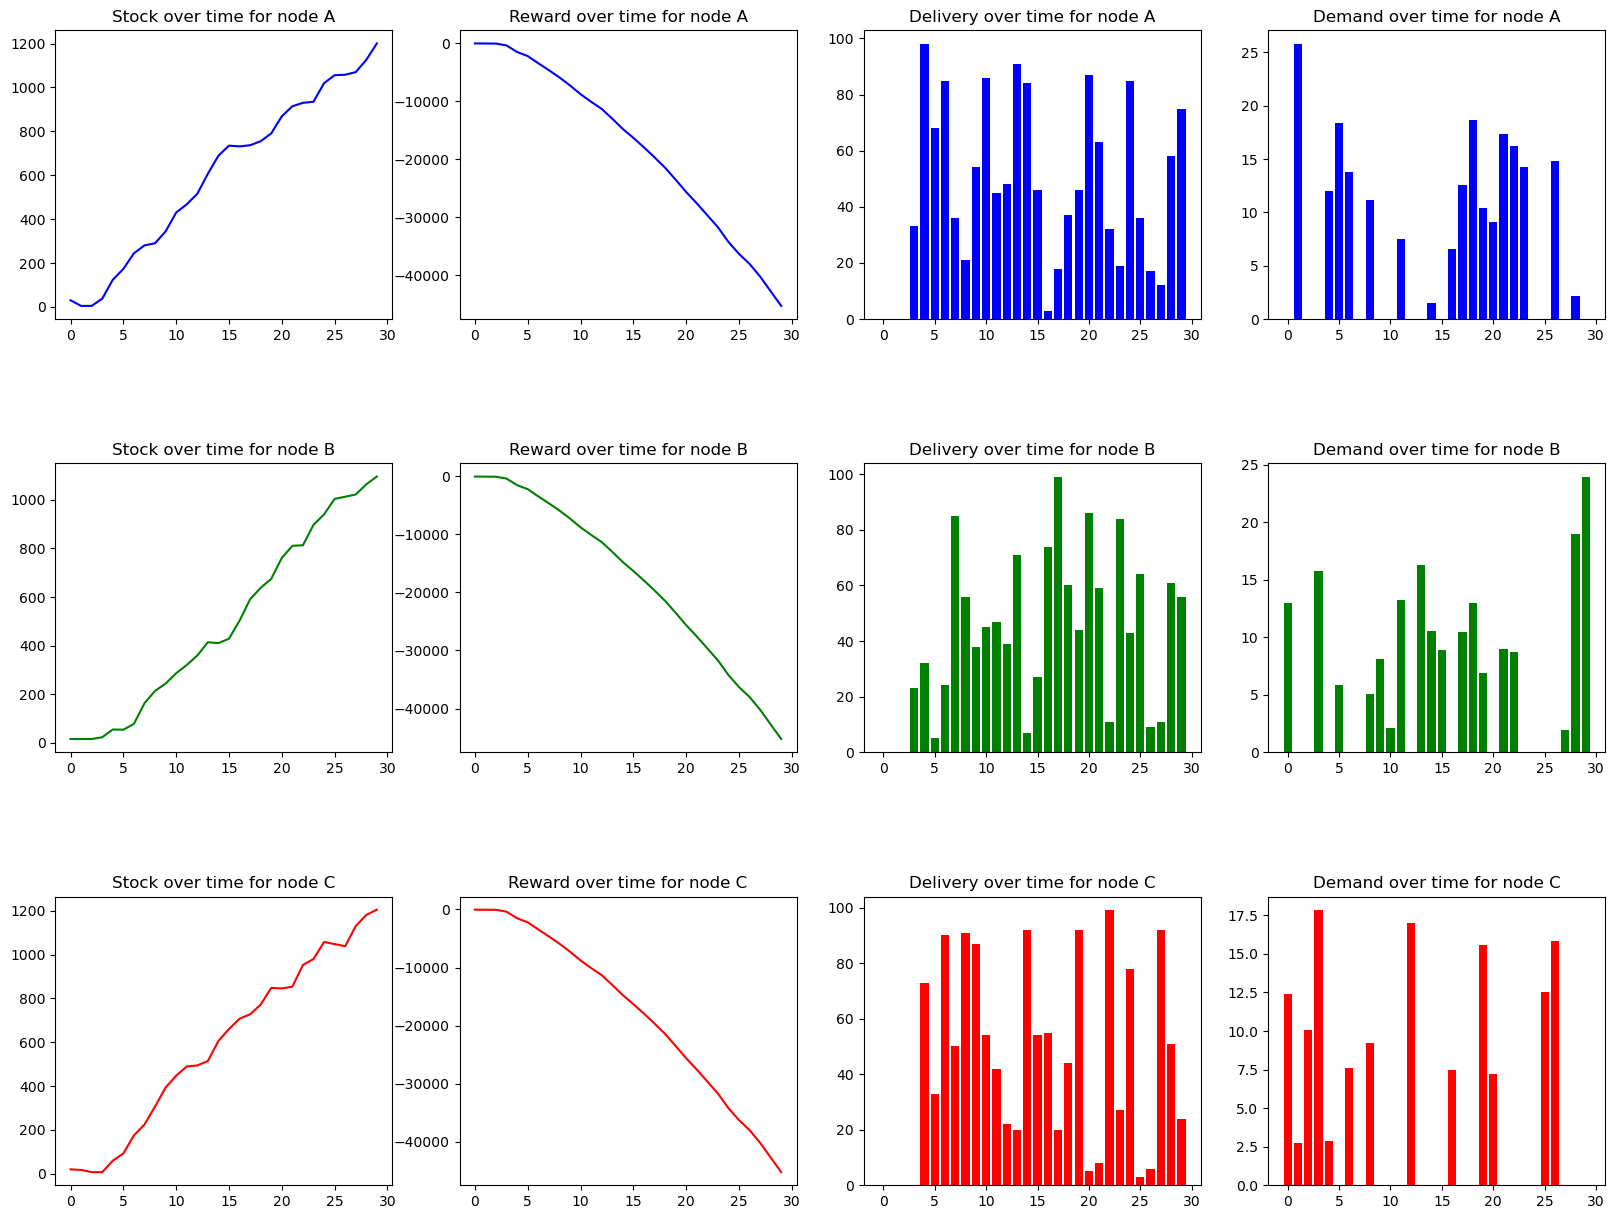

In [27]:
plot_data(df)